In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
data_path = Path('/home/strrl/ssd/score_ml')
years = [2019, 2020, 2021, 2022, 2023, 2024]
files = {
    year: data_path / f'{year}_toxicr_score.parquet' for year in years
}

# load all year data
dfs = {}
for year, file_path in files.items():
    if file_path.exists():
        df = pd.read_parquet(file_path)
        df['year'] = year
        dfs[year] = df

# concat all data
all_data = pd.concat(dfs.values(), ignore_index=True)
print(f"total data: {len(all_data):,} records")
print(f"year distribution: {all_data['year'].value_counts().sort_index()}")


total data: 126,507 records
year distribution: year
2019    18753
2020    15107
2021    17909
2022    13388
2023    21333
2024    40017
Name: count, dtype: int64


In [3]:
score_col = 'score'

# basic statistics
yearly_stats = all_data.groupby('year')[score_col].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: np.percentile(x, 25),  # Q1
    lambda x: np.percentile(x, 75),  # Q3
]).round(4)

yearly_stats.columns = ['count', 'mean', 'median', 'std', 'min', 'max', 'Q1', 'Q3']
print("basic statistics:")
print(yearly_stats)


basic statistics:
      count    mean  median     std     min     max      Q1      Q3
year                                                               
2019  18753  0.0182  0.0040  0.0764  0.0015  0.9974  0.0027  0.0068
2020  15107  0.0181  0.0040  0.0832  0.0015  0.9976  0.0027  0.0069
2021  17909  0.0218  0.0041  0.1020  0.0015  0.9976  0.0028  0.0069
2022  13388  0.0223  0.0042  0.0920  0.0015  0.9977  0.0028  0.0074
2023  21333  0.0274  0.0041  0.0981  0.0015  0.9977  0.0027  0.0077
2024  40017  0.0207  0.0042  0.0849  0.0015  0.9976  0.0027  0.0074


toxic analysis (score > 0.5):
 year  total  toxic  toxic_ratio(%)  non_toxic  non_toxic_ratio(%)
 2019  18753    118            0.63      18635               99.37
 2020  15107    109            0.72      14998               99.28
 2021  17909    209            1.17      17700               98.83
 2022  13388    122            0.91      13266               99.09
 2023  21333    209            0.98      21124               99.02
 2024  40017    303            0.76      39714               99.24


([<matplotlib.axis.XTick at 0x7aae098b86e0>,
 [Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023'),
  Text(2024, 0, '2024')])

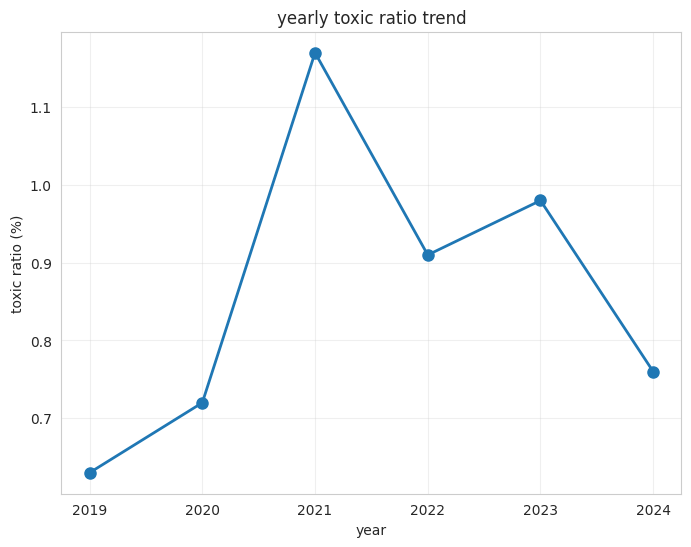

In [4]:
# toxic analysis (score > 0.5)
toxic_threshold = 0.5

# yearly toxic statistics
toxic_stats = []
for year in sorted(dfs.keys()):
    df = dfs[year]
    total_count = len(df)
    toxic_count = len(df[df[score_col] > toxic_threshold])
    toxic_ratio = toxic_count / total_count * 100
    
    toxic_stats.append({
        'year': year,
        'total': total_count,
        'toxic': toxic_count,
        'toxic_ratio(%)': round(toxic_ratio, 2),
        'non_toxic': total_count - toxic_count,
        'non_toxic_ratio(%)': round(100 - toxic_ratio, 2)
    })

toxic_df = pd.DataFrame(toxic_stats)
print("toxic analysis (score > 0.5):")
print(toxic_df.to_string(index=False))

# visualize toxic trend
plt.figure(figsize=(8, 6))
plt.plot(toxic_df['year'], toxic_df['toxic_ratio(%)'], marker='o', linewidth=2, markersize=8)
plt.title('yearly toxic ratio trend')
plt.xlabel('year')
plt.ylabel('toxic ratio (%)')
plt.grid(True, alpha=0.3)
plt.xticks(years)



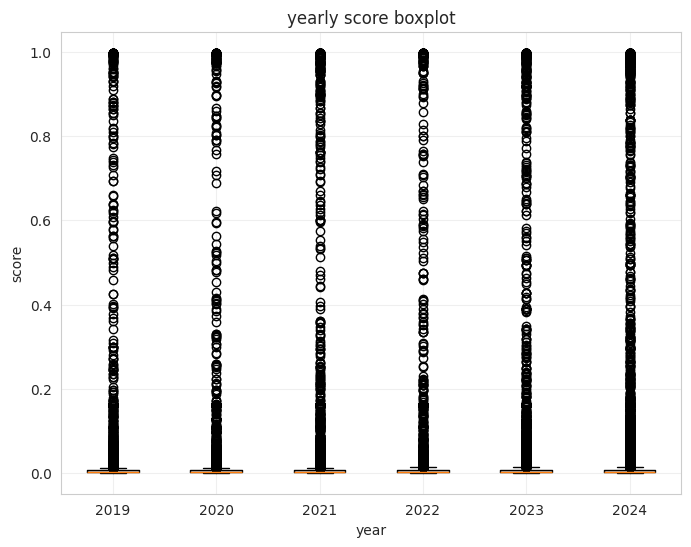

In [5]:
# yearly score distribution comparison
plt.figure(figsize=(8, 6))

# boxplot
yearly_data = [dfs[year][score_col] for year in sorted(dfs.keys())]
plt.boxplot(yearly_data, labels=sorted(dfs.keys()))
plt.title('yearly score boxplot')
plt.xlabel('year')
plt.ylabel('score')
plt.grid(True, alpha=0.3)


yearly interval statistics - count:
year       2019   2020   2021   2022   2023   2024
interval                                          
0.0-0.1   17812  14467  17118  12595  19466  37766
0.1-0.2     783    490    523    627   1580   1821
0.2-0.3      24     16     37     19     37     64
0.3-0.4       9     13     16     15     24     38
0.4-0.5       7     12      6     10     17     25
0.5-0.6      14      9      8     11     13     24
0.6-0.7      11      3     13     11     14     20
0.7-0.8      10      7     19     10     17     32
0.8-0.9      19     15     23      8     27     36
0.9-1.0      64     75    146     82    138    191

yearly interval statistics - ratio(%):
year       2019   2020   2021   2022   2023   2024
interval                                          
0.0-0.1   94.98  95.76  95.58  94.08  91.25  94.37
0.1-0.2    4.18   3.24   2.92   4.68   7.41   4.55
0.2-0.3    0.13   0.11   0.21   0.14   0.17   0.16
0.3-0.4    0.05   0.09   0.09   0.11   0.11   0.09
0.4-0.

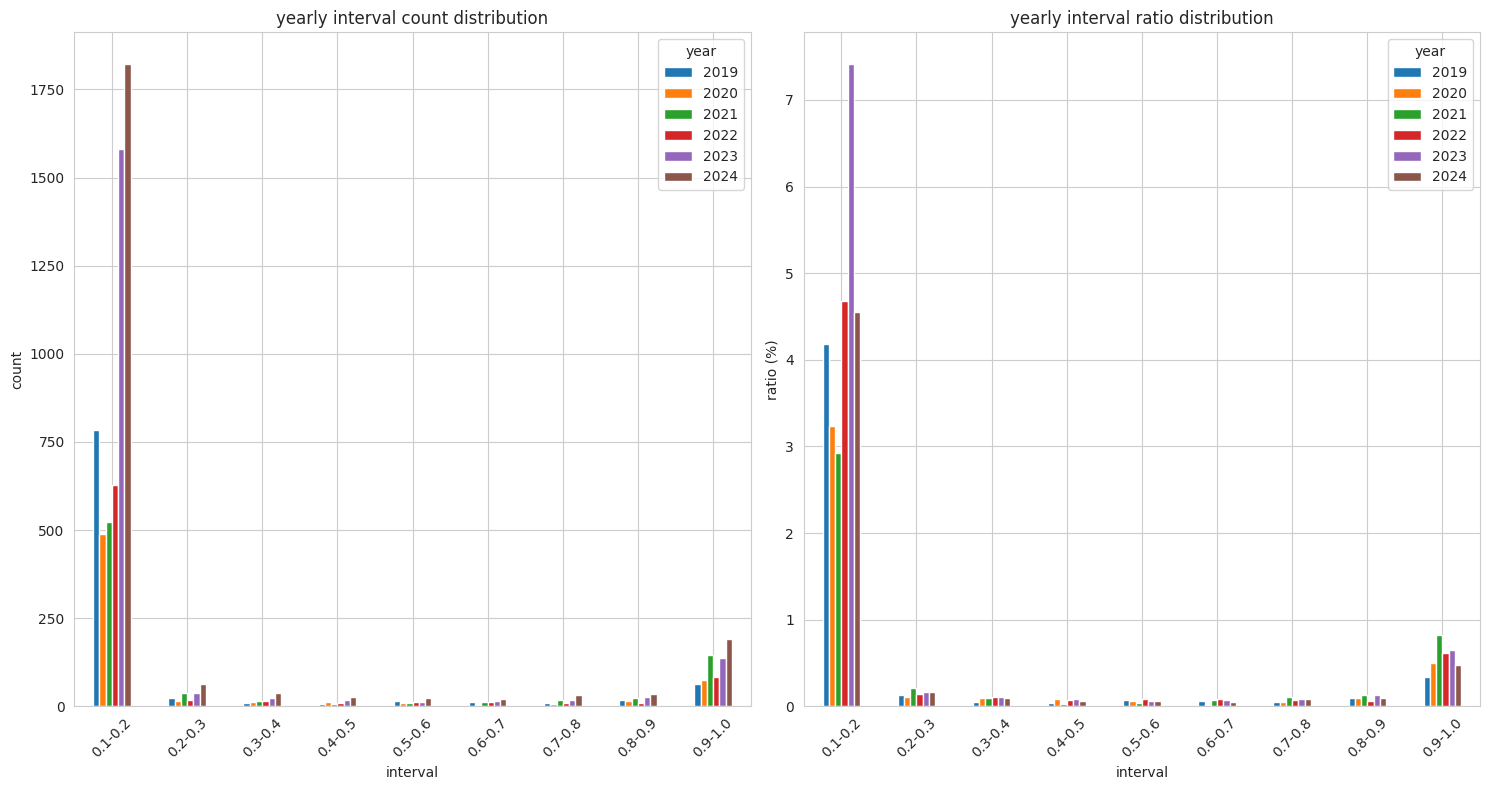

In [6]:
# score interval statistics analysis
# define score intervals
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
          '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# yearly interval statistics
interval_stats = []
for year in sorted(dfs.keys()):
    df = dfs[year]
    interval_counts = pd.cut(df[score_col], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
    interval_percentages = (interval_counts / len(df) * 100).round(2)
    
    for interval, count, pct in zip(interval_counts.index, interval_counts.values, interval_percentages.values):
        interval_stats.append({
            'year': year,
            'interval': interval,
            'count': count,
            'ratio(%)': pct
        })

interval_df = pd.DataFrame(interval_stats)

# create pivot table
pivot_counts = interval_df.pivot(index='interval', columns='year', values='count').fillna(0)
pivot_percentages = interval_df.pivot(index='interval', columns='year', values='ratio(%)').fillna(0)

print("yearly interval statistics - count:")
print(pivot_counts.astype(int))
print("\nyearly interval statistics - ratio(%):")
print(pivot_percentages)

# visualize interval distribution
# only show 0.1-1.0 interval
pivot_counts = pivot_counts.loc[['0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']]
pivot_percentages = pivot_percentages.loc[['0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']]

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
pivot_counts.plot(kind='bar', ax=plt.gca())
plt.title('yearly interval count distribution')
plt.xlabel('interval')
plt.ylabel('count')
plt.legend(title='year')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
pivot_percentages.plot(kind='bar', ax=plt.gca())
plt.title('yearly interval ratio distribution')
plt.xlabel('interval')
plt.ylabel('ratio (%)')
plt.legend(title='year')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [7]:
# extreme value analysis
# yearly extreme high value statistics
extreme_stats = []
for year in sorted(dfs.keys()):
    df = dfs[year]
    
    # top 10 highest score
    top_20 = df.nlargest(20, score_col)[score_col].values
    
    # very high score statistics
    very_high = len(df[df[score_col] >= 0.9])
    
    extreme_stats.append({
        'year': year,
        'highest': df[score_col].max(),
        'very_high': very_high,
        'very_high_ratio(%)': round(very_high / len(df) * 100, 3),
        'top_20_mean': round(top_20.mean(), 4)
    })

extreme_df = pd.DataFrame(extreme_stats)
print("yearly extreme value analysis:")
print(extreme_df.to_string(index=False))


yearly extreme value analysis:
 year  highest  very_high  very_high_ratio(%)  top_20_mean
 2019 0.997392         64               0.341       0.9967
 2020 0.997627         75               0.496       0.9968
 2021 0.997616        146               0.815       0.9974
 2022 0.997671         82               0.612       0.9970
 2023 0.997697        138               0.647       0.9974
 2024 0.997594        191               0.477       0.9972


Annual change rate analysis:
   period  sample_count_change  sample_count_change_rate(%)  mean_change  mean_change_rate(%)  toxic_ratio_change  std_change
2019-2020              -3646.0                       -19.44      -0.0001                -0.55                0.09      0.0068
2020-2021               2802.0                        18.55       0.0037                20.44                0.45      0.0188
2021-2022              -4521.0                       -25.24       0.0005                 2.29               -0.26     -0.0100
2022-2023               7945.0                        59.34       0.0051                22.87                0.07      0.0061
2023-2024              18684.0                        87.58      -0.0067               -24.45               -0.22     -0.0132


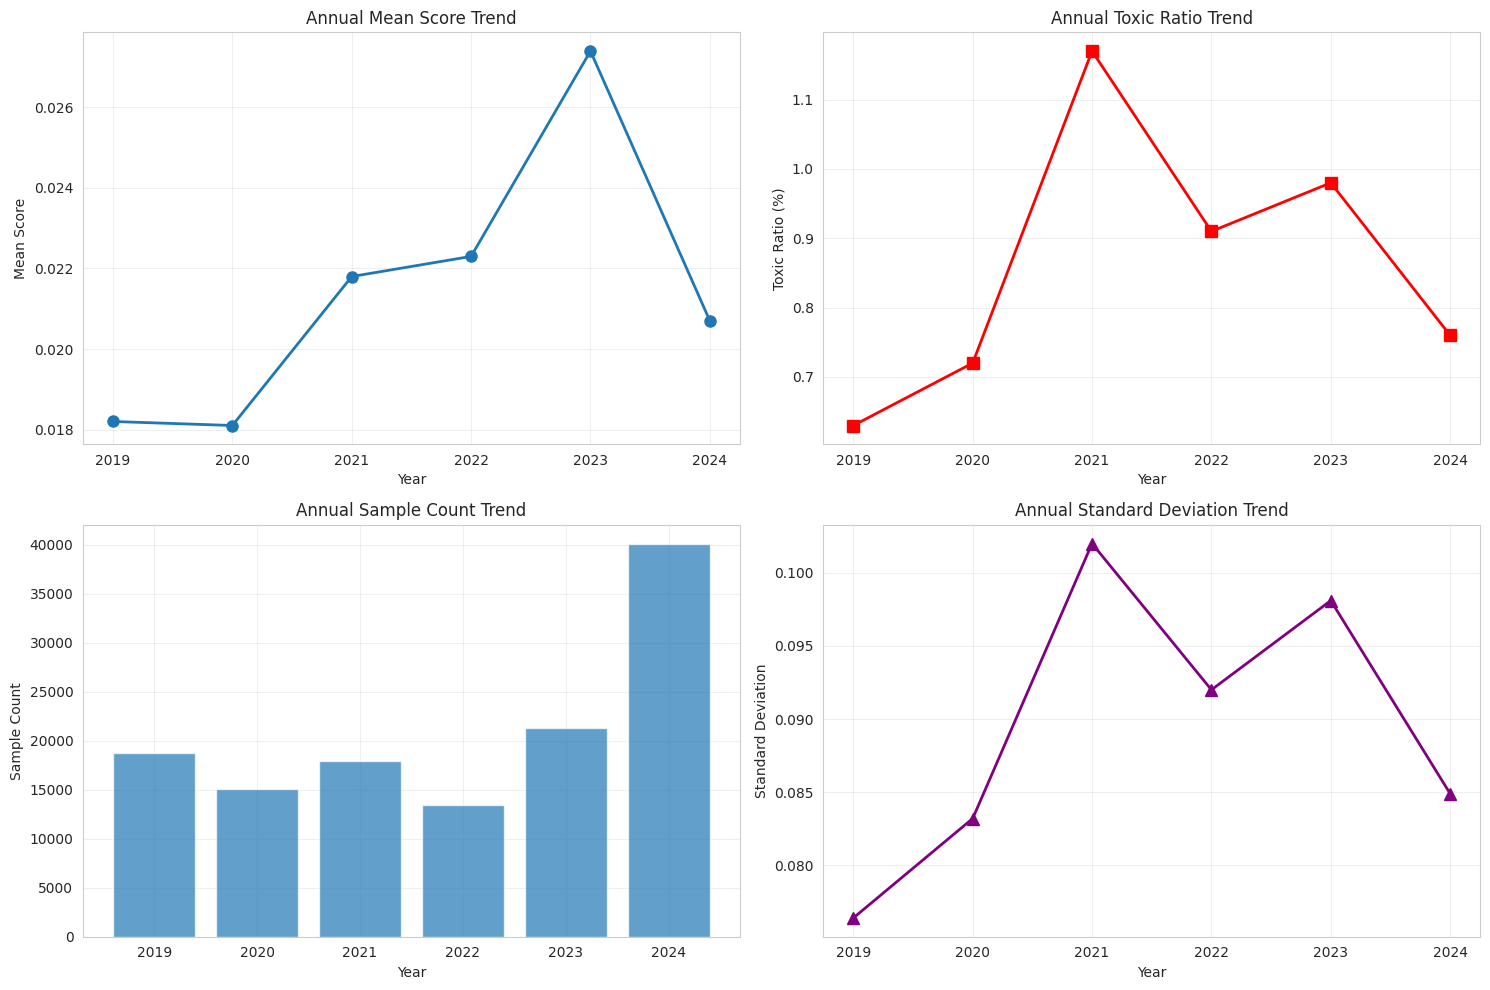

In [8]:
# Annual change rate analysis
change_analysis = []
# years = sorted(dfs.keys())

for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    
    prev_stats = yearly_stats.loc[prev_year]
    curr_stats = yearly_stats.loc[curr_year]
    
    prev_toxic = toxic_df[toxic_df['year'] == prev_year].iloc[0]
    curr_toxic = toxic_df[toxic_df['year'] == curr_year].iloc[0]
    
    change_analysis.append({
        'period': f'{prev_year}-{curr_year}',
        'sample_count_change': curr_stats['count'] - prev_stats['count'],
        'sample_count_change_rate(%)': round((curr_stats['count'] - prev_stats['count']) / prev_stats['count'] * 100, 2),
        'mean_change': round(curr_stats['mean'] - prev_stats['mean'], 4),
        'mean_change_rate(%)': round((curr_stats['mean'] - prev_stats['mean']) / prev_stats['mean'] * 100, 2),
        'toxic_ratio_change': round(curr_toxic['toxic_ratio(%)'] - prev_toxic['toxic_ratio(%)'], 2),
        'std_change': round(curr_stats['std'] - prev_stats['std'], 4),
    })

change_df = pd.DataFrame(change_analysis)
print("Annual change rate analysis:")
print(change_df.to_string(index=False))

# Visualize change trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mean score trend
axes[0,0].plot(yearly_stats.index, yearly_stats['mean'], marker='o', linewidth=2, markersize=8)
axes[0,0].set_title('Annual Mean Score Trend')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Mean Score')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(years)

# Toxic ratio trend
axes[0,1].plot(toxic_df['year'], toxic_df['toxic_ratio(%)'], marker='s', linewidth=2, markersize=8, color='red')
axes[0,1].set_title('Annual Toxic Ratio Trend')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Toxic Ratio (%)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(years)

# Sample count trend
axes[1,0].bar(yearly_stats.index, yearly_stats['count'], alpha=0.7)
axes[1,0].set_title('Annual Sample Count Trend')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Sample Count')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(years)

# Standard deviation trend
axes[1,1].plot(yearly_stats.index, yearly_stats['std'], marker='^', linewidth=2, markersize=8, color='purple')
axes[1,1].set_title('Annual Standard Deviation Trend')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Standard Deviation')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(years)

plt.tight_layout()
plt.show()


In [9]:
# FIXED: Advanced statistical analysis
from scipy import stats

print("Advanced Statistical Analysis:")
print("=" * 40)

# Normality test
print("\nDistribution Feature Analysis:")
for year in sorted(dfs.keys()):
    data = dfs[year][score_col]
    
    # Shapiro-Wilk normality test (may not be suitable for large sample sizes)
    if len(data) <= 5000:  # Limit sample size
        stat, p_value = stats.shapiro(data.sample(min(len(data), 5000)))
        is_normal = "Yes" if p_value > 0.05 else "No"
        print(f"{year}: Skewness={stats.skew(data):.3f}, Kurtosis={stats.kurtosis(data):.3f}, Normal distribution={is_normal}")
    else:
        print(f"{year}: Skewness={stats.skew(data):.3f}, Kurtosis={stats.kurtosis(data):.3f}")

# Statistical significance test between years
print(f"\nSignificance Test Between Years:")
years_list = sorted(dfs.keys())
for i in range(len(years_list)):
    for j in range(i+1, len(years_list)):
        year1, year2 = years_list[i], years_list[j]
        data1 = dfs[year1][score_col]
        data2 = dfs[year2][score_col]
        
        # Mann-Whitney U test (non-parametric test)
        stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        significance = "Significant" if p_value < 0.05 else "Not significant"
        print(f"{year1} vs {year2}: p-value={p_value:.6f}, Difference {significance}")

# Correlation analysis (if time series available)
print(f"\nTime Series Correlation:")
if len(years_list) >= 3:
    # Correlation between year and mean score
    years_numeric = list(yearly_stats.index)
    avg_scores = list(yearly_stats['mean'])
    correlation = stats.pearsonr(years_numeric, avg_scores)
    print(f"Year vs Mean Score correlation coefficient: {correlation[0]:.4f} (p-value: {correlation[1]:.4f})")
    
    # Correlation between year and toxic ratio
    toxic_ratios = [toxic_df[toxic_df['year'] == year]['toxic_ratio(%)'].iloc[0] for year in years_numeric]
    correlation_toxic = stats.pearsonr(years_numeric, toxic_ratios)
    print(f"Year vs Toxic Ratio correlation coefficient: {correlation_toxic[0]:.4f} (p-value: {correlation_toxic[1]:.4f})")

print("\n" + "=" * 40)


Advanced Statistical Analysis:

Distribution Feature Analysis:
2019: Skewness=9.599, Kurtosis=107.341
2020: Skewness=9.621, Kurtosis=102.221
2021: Skewness=8.177, Kurtosis=70.259
2022: Skewness=8.393, Kurtosis=78.919
2023: Skewness=7.434, Kurtosis=64.038
2024: Skewness=8.892, Kurtosis=90.101

Significance Test Between Years:
2019 vs 2020: p-value=0.108434, Difference Not significant
2019 vs 2021: p-value=0.009693, Difference Significant
2019 vs 2022: p-value=0.000000, Difference Significant
2019 vs 2023: p-value=0.000004, Difference Significant
2019 vs 2024: p-value=0.000001, Difference Significant
2020 vs 2021: p-value=0.000066, Difference Significant
2020 vs 2022: p-value=0.000000, Difference Significant
2020 vs 2023: p-value=0.000000, Difference Significant
2020 vs 2024: p-value=0.000000, Difference Significant
2021 vs 2022: p-value=0.001573, Difference Significant
2021 vs 2023: p-value=0.031675, Difference Significant
2021 vs 2024: p-value=0.050506, Difference Not significant
2022 